# Physics 201 A6

## Fan Du


Collaborators: -

In [ ]:
import arviz as az
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd
import pymc as pm
import scipy.signal as sg
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import rcParams
# import pytesseract as pt
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gs
import math
from importlib import reload
from PIL import Image
import matplotlib as mpl
#import tifffile
from matplotlib.font_manager import FontProperties
from scipy import interpolate 
import pylab as pl  
import seaborn as sns
from pprint import pprint
from numpy import cos, sin, tan, sqrt
from matplotlib.colors import LogNorm
#from tqdm import tqdm
from scipy.optimize import fsolve

from math import sin,cos,e, sqrt
from scipy.optimize import least_squares
from pytensor import tensor as pt
import pytest
from pytensor import tensor as pt

[0.67738877 0.66335108 0.62624892 0.64021123]


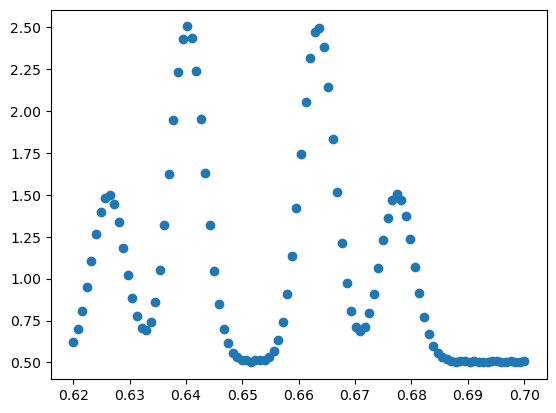

In [ ]:
# create simulated data   will be rewrite!!!!
normf = np.linspace(0.62,0.70,100)    # normalized frequency, "x" 
noisey = np.random.rand(1,100)*0.01   # to norm 
h11 = 0.007
u20 = 0.00005
A0 = 0.5
A1 = 1
A2 =2
A3 =1
A4= 2
sigma_L = 0.003
theta = [h11,u20, A0, A1,A2,A3, A4,sigma_L ]
y0  = ham2(theta,normf)
y = y0+noisey
plt.scatter(normf,y)
# save 

In [ ]:
# H functions
DEG = np.pi/180
twist = 0

def ham2(theta, normf):
    """
    simplify the ham2 function, no external function
    ---
    theta: parameters
    normf: spectrum normalized frequency
    ---
    return: predicted spectrum intensity
    """
    h11,u20, A0, A1,A2,A3,A4, sigma_L = theta
    C = 0.6346    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 1 (*2 degeneracy)
    C2 = 0.669    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 2 (*2 degeneracy)
    #Cn = [C1,C2,C3,C4]
    An = [A1,A2,A3,A4]
    ham = [[C2,h11,u20,h11],
          [h11,C,h11,u20],
          [u20,h11,C,h11],
          [h11,u20,h11,C2]]
    Cn = np.real(np.linalg.eigvals(ham))  # peak position
    # print(Cn)

    line_each = [Ai * np.exp(-(normf - Ci)**2 / (2 * sigma_L**2)) for Ai, Ci in zip(An, Cn)]
    line = np.sum(line_each,axis=0)+A0
    return line   # line, theory

def my_loglike(theta, data, normf,  sigma):
    """
    return loglike likelihood for the spectrum model
    """
    model = ham2(theta, normf)
  
    return -(0.5 / sigma**2) * np.sum((data - model) ** 2)


#========================================================================
### Tensor transform functions
from pytensor import tensor as pt
class Peak_Position(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a vector of peak positions.
    """

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a vector of peak positions

    def __init__(self, Hamiltonian, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.ham = Hamiltonian #your Hamiltonian function goes in here
        self.x = x
        self.data = data 
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain all variables

        # call the loglike function   my_loglike(theta, normf, data, sigma):
        model = self.ham(theta,self.data,self.x,self.sigma)
        
        outputs[0][0] = np.array(model)  # output the eigenvalues

In [ ]:
### model =========================
peaks_model = pm.Model()
peak = Peak_Position(my_loglike, y, normf, 0.02)
with peaks_model:
    # Priors for unknown model parameters    , transform = None  h11, A0, A1, sigma_L = theta
    A0 = pm.Uniform('background',lower=0,upper=1)
    A1 = pm.Uniform("A1", lower=0.5, upper=4)
    A2 = pm.Uniform("A2", lower=1, upper=4)
    A3 = pm.Uniform("A3", lower=1, upper=4)
    A4 = pm.Uniform("A4", lower=1, upper=4)
    h11 = pm.Uniform('h11',lower=0.003,upper=0.01)
    u20 = pm.Uniform('u20',lower=0.00005,upper=0.001)
    # neff = pm.Uniform('neff',2,2.2)         # ignore this for now
    # ratio = pm.Uniform('ratio',0.2,0.4)     # ignore this for now
    sigma_L = pm.Uniform('peak_width',lower=0.001,upper=0.003)
    
    # likelihood
    theta = pt.as_tensor_variable([h11,u20, A0, A1,A2,A3,A4,sigma_L])
    
    # Likelihood of observations
    pm.Potential("likelihood", peak(theta))
    idata_mh = pm.sample(1000, tune=10)

[0.62735377 0.63993647 0.67306353 0.65964623]
[0.62735377 0.63993647 0.67306353 0.65964623]
[0.62735377 0.63993647 0.67306353 0.65964623]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [background]
>Slice: [A1]
>Slice: [A2]
>Slice: [A3]
>Slice: [A4]
>Slice: [h11]
>Slice: [u20]
>Slice: [peak_width]


[0.62735377 0.63993647 0.67306353 0.65964623]


Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 103 seconds.


array([[<AxesSubplot: title={'center': 'background'}>,
        <AxesSubplot: title={'center': 'background'}>],
       [<AxesSubplot: title={'center': 'A1'}>,
        <AxesSubplot: title={'center': 'A1'}>],
       [<AxesSubplot: title={'center': 'A2'}>,
        <AxesSubplot: title={'center': 'A2'}>],
       [<AxesSubplot: title={'center': 'A3'}>,
        <AxesSubplot: title={'center': 'A3'}>],
       [<AxesSubplot: title={'center': 'A4'}>,
        <AxesSubplot: title={'center': 'A4'}>],
       [<AxesSubplot: title={'center': 'h11'}>,
        <AxesSubplot: title={'center': 'h11'}>],
       [<AxesSubplot: title={'center': 'u20'}>,
        <AxesSubplot: title={'center': 'u20'}>],
       [<AxesSubplot: title={'center': 'peak_width'}>,
        <AxesSubplot: title={'center': 'peak_width'}>]], dtype=object)

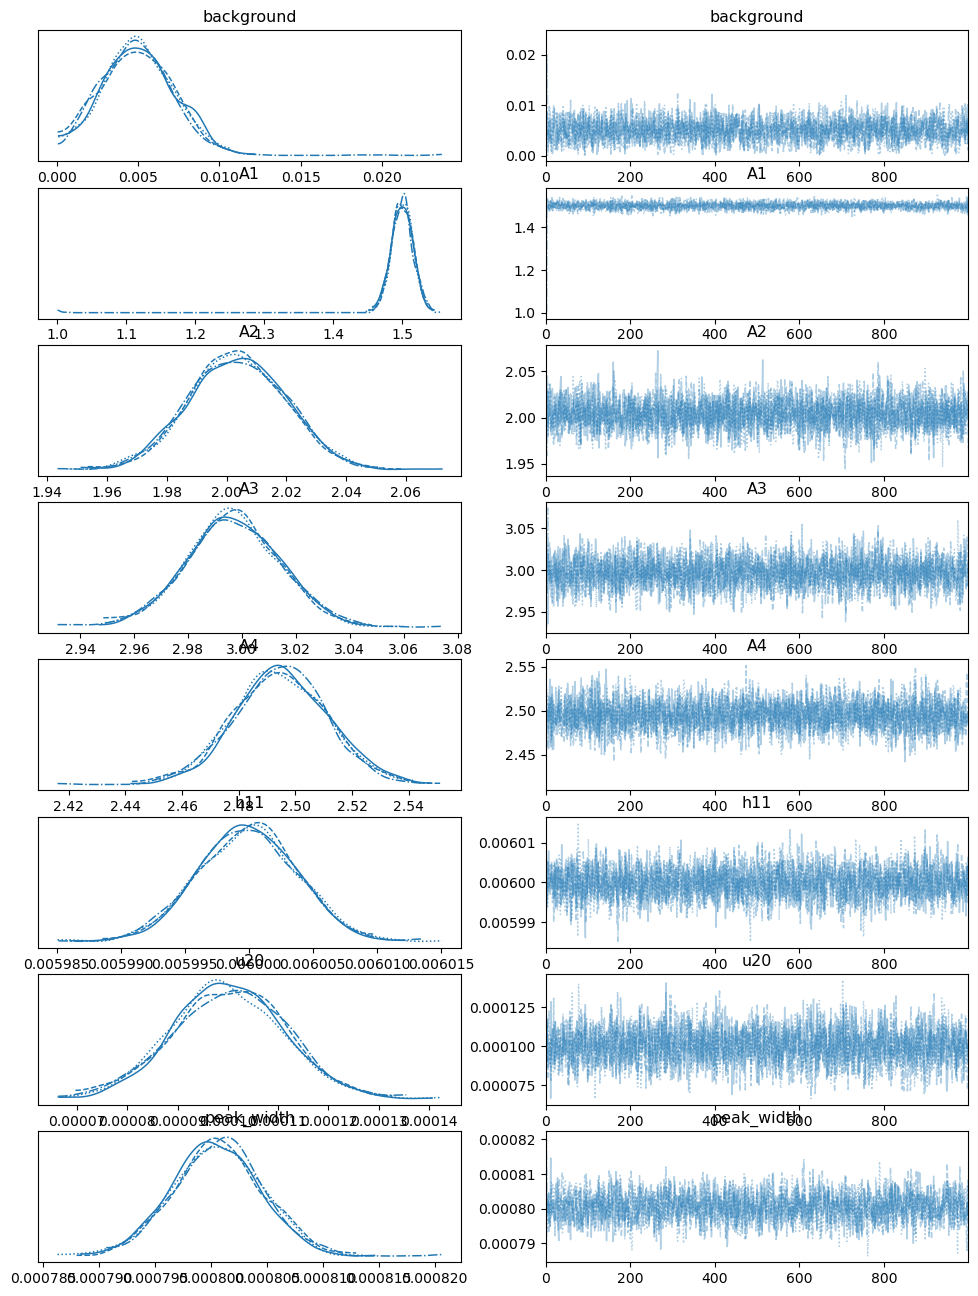

In [ ]:
az.plot_trace(idata_mh)

# real data

I would fix all the diagonal elements, only change off-diagonal elements and vectorize them. 

[ 29.799      104.84833333]


<ErrorbarContainer object of 3 artists>

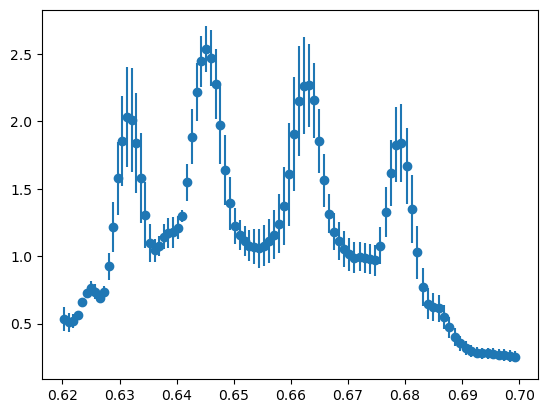

In [ ]:
# load processed data from npy
exp_data0 = np.load('expdata_GM0.05.npy')
alpha = 90*DEG
#
a = 1000e-9  # lattice constant of phc
c = 299792458
normf0 = exp_data0[0]*1e12*a/c

y_cut = [0.62,0.7]
cut = len(normf0)*(y_cut-np.min(normf0))/(np.max(normf0)-np.min(normf0))
normf = normf0[(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]
print(cut)
#exp_data = exp_data0[:,int(cut[0]):int(cut[1])]
frequency = exp_data0[0][(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]
normf = frequency*1e12*a/c
y = exp_data0[1][(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]
sigmay = exp_data0[2][(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]

plt.errorbar(normf,y,sigmay,fmt='o')


[0.64516129 0.66312997 0.63131313 0.67934783]


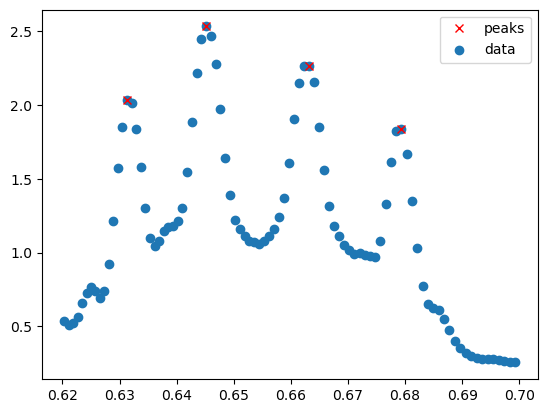

In [ ]:
# parameters to infer  h11=h11, v11=v11, u20=u20, neff=neff, ratio=ratio
# find peaks as initial value
peaks, _ = sg.find_peaks(y, height=1.8, distance=1,width = 1.5)

chose_peak = np.vstack((y[peaks],normf[peaks])).T
indices = np.argsort(chose_peak[:, 0])[::-1]
chose_peak = chose_peak[indices]
# print(chose_peak)
plt.plot(chose_peak[:,1], chose_peak[:,0], "x",c = 'r',label = 'peaks')
plt.scatter(normf,y,label = 'data');
plt.legend()
print(chose_peak[:,1])

In [ ]:
### model =========================
peaks_model = pm.Model()
peak = Peak_Position(my_loglike, y, normf, 0.01)
with peaks_model:
    # Priors for unknown model parameters    , transform = None  h11, A0, A1, sigma_L = theta
    A0 = pm.Uniform('background',lower=0,upper=1.2)
    A1 = pm.Uniform("A1", lower=0.5, upper=2.5)
    A2 = pm.Uniform("A2", lower=0.5, upper=2.5)
    A3 = pm.Uniform("A3", lower=0.5, upper=2.5)
    A4 = pm.Uniform("A4", lower=0.5, upper=2.5)
    h11 = pm.Uniform('h11',lower=0.003,upper=0.01)
    u20 = pm.Uniform('u20',lower=-1e-3,upper=1e-3)
    # neff = pm.Uniform('neff',2,2.2)         # ignore this for now
    # ratio = pm.Uniform('ratio',0.2,0.4)     # ignore this for now
    sigma_L = pm.Uniform('peak_width',lower=0.0005,upper=0.01)
    
    # likelihood
    theta = pt.as_tensor_variable([h11,u20, A0, A1,A2,A3,A4, sigma_L])
    
    # Likelihood of observations
    pm.Potential("likelihood", peak(theta))
    idata_mh = pm.sample(1000, tune=10)

[0.67668722 0.66368722 0.62691278 0.63991278]
[0.67668722 0.66368722 0.62691278 0.63991278]
[0.67668722 0.66368722 0.62691278 0.63991278]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [background]
>Slice: [A1]
>Slice: [A2]
>Slice: [A3]
>Slice: [A4]
>Slice: [h11]
>Slice: [u20]
>Slice: [peak_width]


[0.67668722 0.66368722 0.62691278 0.63991278]


Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 128 seconds.


array([[<AxesSubplot: title={'center': 'background'}>,
        <AxesSubplot: title={'center': 'background'}>],
       [<AxesSubplot: title={'center': 'A1'}>,
        <AxesSubplot: title={'center': 'A1'}>],
       [<AxesSubplot: title={'center': 'A2'}>,
        <AxesSubplot: title={'center': 'A2'}>],
       [<AxesSubplot: title={'center': 'A3'}>,
        <AxesSubplot: title={'center': 'A3'}>],
       [<AxesSubplot: title={'center': 'A4'}>,
        <AxesSubplot: title={'center': 'A4'}>],
       [<AxesSubplot: title={'center': 'h11'}>,
        <AxesSubplot: title={'center': 'h11'}>],
       [<AxesSubplot: title={'center': 'u20'}>,
        <AxesSubplot: title={'center': 'u20'}>],
       [<AxesSubplot: title={'center': 'peak_width'}>,
        <AxesSubplot: title={'center': 'peak_width'}>]], dtype=object)

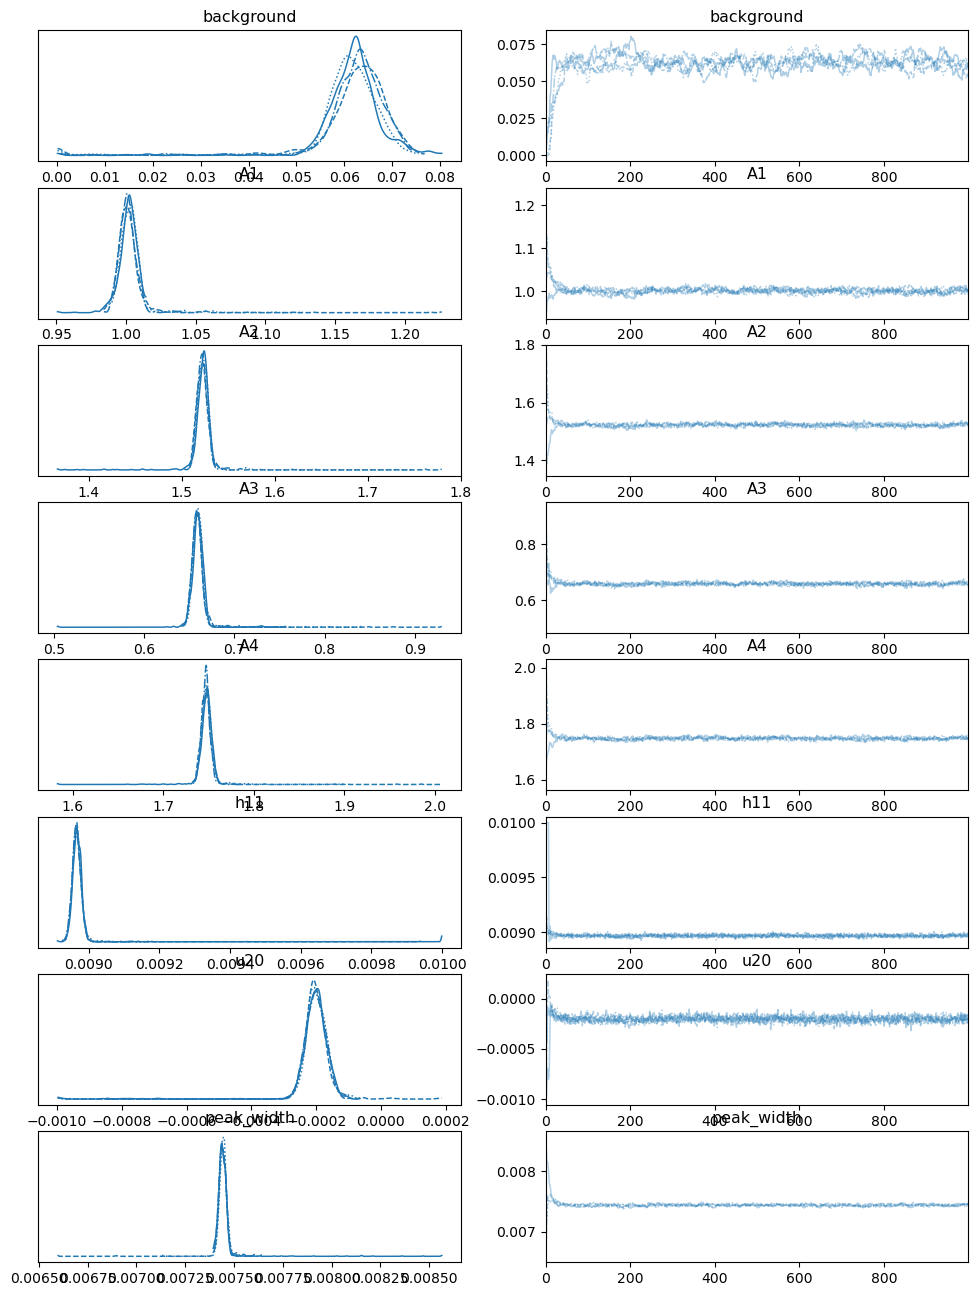

In [ ]:
az.plot_trace(idata_mh); 